# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Load-geometries-to-analyze" data-toc-modified-id="Load-geometries-to-analyze-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load geometries to analyze</a></div><div class="lev2 toc-item"><a href="#Analyze-loss/gain-Wildlife-places" data-toc-modified-id="Analyze-loss/gain-Wildlife-places-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Analyze loss/gain Wildlife places</a></div><div class="lev2 toc-item"><a href="#analyze-burned-areas" data-toc-modified-id="analyze-burned-areas-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>analyze burned areas</a></div><div class="lev2 toc-item"><a href="#analyze-Glad" data-toc-modified-id="analyze-Glad-04"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>analyze Glad</a></div><div class="lev2 toc-item"><a href="#analyze-precipitation" data-toc-modified-id="analyze-precipitation-05"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>analyze precipitation</a></div><div class="lev2 toc-item"><a href="#ndvi" data-toc-modified-id="ndvi-06"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>ndvi</a></div><div class="lev2 toc-item"><a href="#temperatures" data-toc-modified-id="temperatures-07"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>temperatures</a></div><div class="lev2 toc-item"><a href="#species-richness" data-toc-modified-id="species-richness-08"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>species richness</a></div><div class="lev2 toc-item"><a href="#snow-and-ice" data-toc-modified-id="snow-and-ice-09"><span class="toc-item-num">0.9&nbsp;&nbsp;</span>snow and ice</a></div><div class="lev2 toc-item"><a href="#Water-change" data-toc-modified-id="Water-change-010"><span class="toc-item-num">0.10&nbsp;&nbsp;</span>Water change</a></div><div class="lev2 toc-item"><a href="#droughts?" data-toc-modified-id="droughts?-011"><span class="toc-item-num">0.11&nbsp;&nbsp;</span>droughts?</a></div>

In [1]:
import geopandas as gpd
import ee; ee.Initialize()
import json
import pandas as pd  
import numpy as np
import datetime
import json
import requests
import matplotlib.pyplot as plt

## Load geometries to analyze

In [3]:
with open('new-locations-with-geostore.json') as data:
    dashboards = json.loads(data.read())

In [ ]:
#myD= dashboards[12]['geojson']['features']
#myD[0]['properties']={}
#myD[0]['crs']={
#  "type": "name",
#  "properties": {
#    "name": "epsg:3857"
#    }
#  }
#print(json.dumps(myD))
#gdf = gpd.GeoDataFrame.from_features(myD)

In [ ]:
#gdf.crs = {'init' :'epsg:3857'}
#gdf.plot()
#gdfR = gdf.to_crs({'init': 'epsg:4326'})
#gdfR.plot()

Select only Okavango Delta

In [4]:
dashboards = [a for a in dashboards if a['name'] in 'Okavango Delta']
#dashboards = [a for a in dashboards if a['name'] in 'TwoCrow_leased']
#dashboards = [a for a in dashboards if a['name'] in 'Osa_Peninsula.dbf']
#dashboards = [a for a in dashboards if a['name'] in 'TwoCrow_deeded']

In [5]:
[dashboard['geojson']['features'][0].update({"properties": {'slug':dashboard['name'], 'areaHa':dashboard['areaHa'], 'geostore_id': dashboard['geostore_id']}}) for dashboard in dashboards]
geometries = [dict(dashboard['geojson']['features'][0]) for dashboard in dashboards]
for idx, item in enumerate(geometries):
    if len(np.array(item['geometry']['coordinates']).shape)>3:
        geometries[idx]['geometry']['coordinates'] = item['geometry']['coordinates'][0]
collection = ee.FeatureCollection(geometries)

## Analyze loss/gain Wildlife places

In [7]:
lwp = ee.Image.pixelArea().mask(ee.Image('users/adampain/LWPs_binary_WGS84'))
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.sum(),
    'scale':180,
    #'bestEffort':True,
    'tileScale': 16
}
RegionslwpA = lwp.reduceRegions(**regReducer).toList(10000).getInfo()
lwpA ={}
for region in RegionslwpA:
    lwpA[region['properties']['slug']]=region['properties']['sum']/10000
    print()
print(lwpA)


{'Okavango Delta': 2037337.4296075916}


In [8]:
wpLossG = ee.ImageCollection('users/Aliciaarenzana/natGeo/lossGainWPN')
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.sum(),
    'scale':90,
    'tileScale': 16
}
def reduce2Regions(img):
    loss = ee.Image.pixelArea().rename(['loss']).mask(img.select('loss'))
    gain = ee.Image.pixelArea().rename(['gain']).mask(img.select('gain'))

    reduction = loss.addBands(gain).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test': reduction.toList(1000000)})))

imReduced = wpLossG.map(reduce2Regions).toList(1000)
myOutput = imReduced.getInfo()
output=[]
#print(myOutput)
for year in myOutput:
    for region in year['properties']['test']:
         output.append({'year':year['properties']['date'], 
                        'WLPbasHa':lwpA[region['properties']['slug']],
                        'regionAreaHa':region['properties']['areaHa'], 
                        'lossHa':region['properties']['loss']/10000,
                        'gainHa':region['properties']['gain']/10000,
                        'index': ((lwpA[region['properties']['slug']] - (region['properties']['loss']/10000) +(region['properties']['gain']/10000))/lwpA[region['properties']['slug']]), 
                        'slug':region['properties']['slug']})

with open('LossGainWLP.json', 'w') as outfile:
    json.dump(output, outfile)

## analyze burned areas

In [9]:
### ASSETS from GEE lets prepare it to what we need
BurnedAreas= ee.ImageCollection('MODIS/006/MCD64A1').select('BurnDate')
### Reducer to group images
imReducer = {
    'reducer':ee.Reducer.lastNonNull(),
    'parallelScale':10
}
### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.frequencyHistogram().unweighted(),
    'scale':500,
    'tileScale': 16
}
#mapable function to extract geometries
def reduce2Regions(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(100)})))

# grouping images by date (this only work if we have DOY as pixels values)
listYimages=[BurnedAreas.filterDate( ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD((year+1), 12, 31)).reduce(**imReducer) for year in range(2000, datetime.datetime.now().year)]

# once we have the yearly image production we should reduced to the regions per each year
imReduced=ee.List(listYimages).map(reduce2Regions)
myOutput=imReduced.getInfo()

#reshaping the data (this can also be done in earth engine but is a pain in the ass)
output=[]
for position, year in enumerate(myOutput):
    for region in year['properties']['test']: 
        hist= [{'year':2001+position,'isoWeek':i,'value':0, 'slug':region['properties']['slug']} for i in range(1,54)]
        for key, value in region['properties']['histogram'].items(): #this loop will visit every geometry in every year to agg them into weekly weeks
            if key != 'null':
                myDoy=datetime.datetime(2001+position, 1, 1) + datetime.timedelta(days=int(key)-1)
                week = myDoy.isocalendar()[1]
                hist[week-1]['value'] += value

        output.extend(hist)
with open('burnAreas.json', 'w') as outfile:
    json.dump(output, outfile)
    

## analyze Glad

In [10]:
#From the API
api_asset = '2563cd1a-07d5-4621-99a0-c4a241c4f6b0'

def getData(geostore):
    query = """
    select count(year) as value, year, julian_day from Expanded-GLAD-alerts where confidence_text='confirmed' group by year, julian_day
    """
    params = {
        'sql':query,
        'geostore':geostore

    }
    print(geostore)
    r = requests.get('http://api.resourcewatch.org/v1/query/{0}'.format(api_asset),params=params)
    print(r.text)
    if r.status_code == 200:
        return r.json()['data']

def createGeostore(feature):
    headers={
        "Content-Type":"application/json"
    }
    params = {
        "geojson": {
      "type":"FeatureCollection",
      "features":[feature]}

    }

    r = requests.post('https://api.resourcewatch.org/v1/geostore',data=json.dumps(params), headers=headers)
    if r.status_code == 200:
        return r.json()['data']['id']
    else:
            return [{}]
output=[]    
for region in geometries:
    geostore=createGeostore(region)
    hist= [{'year':year,'isoWeek':i,'value':0, 'slug':region['properties']['slug']} for year in range(2015,2019) for i in range(1,54)]
    data = getData(geostore)
    for row in data: #this loop will visit every year to agg them into weekly weeks
        myDoy=datetime.datetime(row['year'], 1, 1) + datetime.timedelta(days=row['julian_day']-1)
        week = myDoy.isocalendar()[1]
        hist[((row['year']-2014)*week)-1]['value'] += row['value']

    output.extend(hist)

with open('gladAlerts.json', 'w') as outfile:
    json.dump(output, outfile)

35786c52d8372ce96c8d07827099ea0e
{"errors":[{"status":404,"detail":"Endpoint not found"}]}


TypeError: 'NoneType' object is not iterable

In [11]:
### From Gee
### ASSETS from GEE lets prepare it to what we need
Glad2017= ee.ImageCollection('projects/glad/alert/UpdResult').select(['alertDate17']).filterDate( ee.Date.fromYMD(2018, 1, 1), ee.Date.fromYMD(2018, 6, 30)).mosaic()
Glad2018= ee.ImageCollection('projects/glad/alert/UpdResult').select(['alertDate18']).mosaic()

### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.frequencyHistogram().unweighted(),
    'scale':500,
    'tileScale': 16
}
#mapable function to extract geometries
def reduce2Regions(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(100)})))

# grouping images by date (this only work if we have DOY as pixels values)
listYimages=[Glad2017, Glad2018]

# once we have the yearly image production we should reduced to the regions per each year
imReduced=ee.List(listYimages).map(reduce2Regions)
myOutput=imReduced.getInfo()

#reshaping the data (this can also be done in earth engine but is a pain in the ass)
output=[]
for position, year in enumerate(myOutput):
    for region in year['properties']['test']: 
        hist= [{'year':2017+position,'isoWeek':i,'value':0, 'slug':region['properties']['slug']} for i in range(1,53)]
        for key, value in region['properties']['histogram'].items(): #this loop will visit every geometry in every year to agg them into weekly weeks
            if key != 'null':
                myDoy=datetime.datetime(2018, 1, 1) + datetime.timedelta(days=int(key)-1)
                week = myDoy.isocalendar()[1]
                hist[week-1]['value'] += value

        output.extend(hist)
with open('Glad.json', 'w') as outfile:
    json.dump(output, outfile)

## analyze precipitation

In [12]:
### ASSETS from GEE lets prepare it to what we need
chirps= ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
### Reducer to group images
imReducer = {
    'reducer':ee.Reducer.sum(),
    'parallelScale':100
}
### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.mean(),
    'scale':5600,
    'tileScale': 16
}
#mapable function to extract geometries
def reduce2Regions(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)})))
## manage dates
def weekCalc(myTime):
    x=(8-myTime.isocalendar()[2])
    newDate = myTime + datetime.timedelta(days=x)
    return {'week': newDate.isocalendar()[1],'year':newDate.isocalendar()[0], 'month':newDate.month, 'epoch':newDate.timestamp()*1000}
# grouping images by date (for precipitation lets see the cummulative precipitation per week)
#date management: we need a date management that can reduce every day of the year to its correspondent week + year. we are going to use this to reduce the size of the image to something more...

output=[]
for year in range(1981, 2019):
    if year == 2018:
        endDate = datetime.datetime.fromtimestamp(1535673600)
    else:
        endDate = datetime.datetime(year+1, 1, 1)
    #mDate = datetime.datetime.fromtimestamp(347155200)
    mDate = datetime.datetime(year, 1, 1)
    listDates=[]
    while mDate < endDate:
        dateW= weekCalc(mDate)
        mDate =datetime.datetime.fromtimestamp(dateW['epoch']/1000)
        listDates.append(dateW)
    
    listYimages=[chirps.filterDate(ee.Date(listDates[ix]['epoch']), ee.Date(listDates[ix+1]['epoch'])).reduce(**imReducer).setMulti({'year':date['year'],'week':date['week'], 'month':date['month']}) for ix, date in enumerate(listDates) if ix < (len(listDates)-1)]

    print(year, len(listYimages))
# once we have the yearly image production we should reduced to the regions per each year

    imReduced=ee.List(listYimages).map(reduce2Regions)
    myOutput = imReduced.getInfo()
    for position, weekY in enumerate(myOutput):
        for region in weekY['properties']['test']: 
            output.append({'year': weekY['properties']['year'],'isoWeek': weekY['properties']['week'],'value': region['properties']['mean'], 'slug':region['properties']['slug']})

with open('chirps_weekly-2017.json', 'w') as outfile:
    json.dump(output, outfile)

1981 52
1982 52
1983 52
1984 53
1985 52
1986 52
1987 52
1988 52
1989 52
1990 52
1991 52
1992 52
1993 52
1994 52
1995 52
1996 52
1997 52
1998 52
1999 52
2000 52
2001 52
2002 52
2003 52
2004 52
2005 52
2006 52
2007 52
2008 52
2009 52
2010 52
2011 52
2012 53
2013 52
2014 52
2015 52
2016 52
2017 52
2018 34


## ndvi

In [13]:
### ASSETS from GEE lets prepare it to what we need
ndvi= ee.ImageCollection('MODIS/MOD09GA_NDVI').select(0)
### Reducer to group images
imReducer = {
    'reducer':ee.Reducer.mean(),
    'parallelScale':50
}
### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.mean(),
    'scale':5600,
    'crs':'EPSG:4326',
    'tileScale': 16
}
#mapable function to extract geometries
def reduce2Regions(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)})))
## manage dates
def weekCalc(myTime):
    x=(8-myTime.isocalendar()[2])
    newDate = myTime + datetime.timedelta(days=x)
    return {'week': newDate.isocalendar()[1],'year':newDate.isocalendar()[0], 'month':newDate.month, 'epoch':newDate.timestamp()*1000}
# grouping images by date (for precipitation lets see the cummulative precipitation per week)
#date management: we need a date management that can reduce every day of the year to its correspondent week + year. we are going to use this to reduce the size of the image to something more...

output=[]
## fill the numbers with your selected years
for year in range(2005, 2018):
    if year == 2017:
        endDate = datetime.datetime.fromtimestamp(1490832000)
    else:
        endDate = datetime.datetime(year+1, 1, 1)
    mDate = datetime.datetime(year, 1, 1)
    listDates=[]
    while mDate < endDate:
        dateW= weekCalc(mDate)
        mDate =datetime.datetime.fromtimestamp(dateW['epoch']/1000)
        listDates.append(dateW)
    
    listYimages=[ndvi.filterDate(ee.Date(listDates[ix]['epoch']), ee.Date(listDates[ix+1]['epoch'])).reduce(**imReducer).setMulti({'year':date['year'],'week':date['week'], 'month':date['month']}) for ix, date in enumerate(listDates) if ix < (len(listDates)-1)]

    print(year, len(listYimages))
# once we have the yearly image production we should reduced to the regions per each year

    imReduced=ee.List(listYimages).map(reduce2Regions)
    myOutput = imReduced.getInfo()
    for position, weekY in enumerate(myOutput):
        for region in weekY['properties']['test']: 
            output.append({'year': weekY['properties']['year'],'isoWeek': weekY['properties']['week'],'value': region['properties']['mean'] if 'mean' in region['properties'] else None, 'slug':region['properties']['slug']})

with open('ndvi_weekly-2017.json', 'w') as outfile:
    json.dump(output, outfile)

2005 52
2006 52
2007 52
2008 52
2009 52
2010 52
2011 52
2012 53
2013 52
2014 52
2015 52
2016 52
2017 13


## temperatures

https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1

In [25]:
### ASSETS from GEE lets prepare it to what we need
temperature= ee.ImageCollection('MODIS/006/MOD11A1')
temperature=temperature.select('LST_Day_1km')
### Reducer to group images
imReducer = {
    'reducer':ee.Reducer.mean(),
    'parallelScale':50
}
### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.mean(),
    'scale':5600,
    'crs':'EPSG:4326',
    'tileScale': 16
}
#mapable function to extract geometries
def reduce2Regions(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)})))
## manage dates
def weekCalc(myTime):
    x=(8-myTime.isocalendar()[2])
    newDate = myTime + datetime.timedelta(days=x)
    return {'week': newDate.isocalendar()[1],'year':newDate.isocalendar()[0], 'month':newDate.month, 'epoch':newDate.timestamp()*1000}
# grouping images by date (for precipitation lets see the cummulative precipitation per week)
#date management: we need a date management that can reduce every day of the year to its correspondent week + year. we are going to use this to reduce the size of the image to something more...

output=[]
## fill the numbers with your selected years
for year in range(2005, 2018):
    if year == 2017:
        endDate = datetime.datetime.fromtimestamp(1490832000)
    else:
        endDate = datetime.datetime(year+1, 1, 1)
    mDate = datetime.datetime(year, 1, 1)
    listDates=[]
    while mDate < endDate:
        dateW= weekCalc(mDate)
        mDate =datetime.datetime.fromtimestamp(dateW['epoch']/1000)
        listDates.append(dateW)
    
    listimages=[temperature.filterDate(ee.Date(listDates[ix]['epoch']), ee.Date(listDates[ix+1]['epoch'])).reduce(**imReducer).setMulti({'year':date['year'],'week':date['week'], 'month':date['month']}) for ix, date in enumerate(listDates) if ix < (len(listDates)-1)]

    print(year, len(listimages))
# once we have the yearly image production we should reduced to the regions per each year

    imReduced=ee.List(listimages).map(reduce2Regions)
    myOutput = imReduced.getInfo()
    for position, weekY in enumerate(myOutput):
        for region in weekY['properties']['test']: 
            output.append({'year': weekY['properties']['year'],'isoWeek': weekY['properties']['week'],'value': region['properties']['mean']*0.02-273.15 if 'mean' in region['properties'] else None, 'slug':region['properties']['slug']})

with open('temperature_weekly-2017.json', 'w') as outfile:
    json.dump(output, outfile)

2005 52
2006 52
2007 52
2008 52
2009 52
2010 52
2011 52
2012 53
2013 52
2014 52
2015 52
2016 52
2017 13


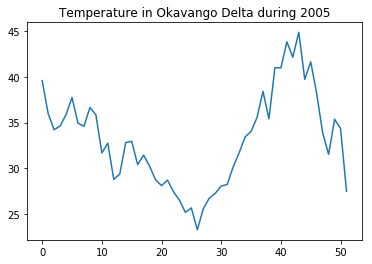

In [26]:
parameter = 'Temperature'
year = [2005]
aoi = ['Okavango Delta']

param = [a for a in output if a['year'] in year]

y = []

for i in range(len(param)):
    y.append(param[i]['value'])
    
plt.plot(np.arange(len(y)),y)
plt.title (parameter+' in '+aoi[0]+' during '+str(year[0]));

## snow and ice

https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MYD10A1

In [18]:
### ASSETS from GEE lets prepare it to what we need
snow = ee.ImageCollection('MODIS/006/MYD10A1')
snow = snow.select('NDSI_Snow_Cover')
### Reducer to group images
imReducer = {
    'reducer':ee.Reducer.mean(),
    'parallelScale':50
}
### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.mean(),
    'scale':5600,
    'crs':'EPSG:4326',
    'tileScale': 16
}
#mapable function to extract geometries
def reduce2Regions(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    return ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)})))
## manage dates
def weekCalc(myTime):
    x=(8-myTime.isocalendar()[2])
    newDate = myTime + datetime.timedelta(days=x)
    return {'week': newDate.isocalendar()[1],'year':newDate.isocalendar()[0], 'month':newDate.month, 'epoch':newDate.timestamp()*1000}
# grouping images by date (for precipitation lets see the cummulative precipitation per week)
#date management: we need a date management that can reduce every day of the year to its correspondent week + year. we are going to use this to reduce the size of the image to something more...

output=[]
## fill the numbers with your selected years
for year in range(2005, 2018):
    if year == 2017:
        endDate = datetime.datetime.fromtimestamp(1490832000)
    else:
        endDate = datetime.datetime(year+1, 1, 1)
    mDate = datetime.datetime(year, 1, 1)
    listDates=[]
    while mDate < endDate:
        dateW= weekCalc(mDate)
        mDate =datetime.datetime.fromtimestamp(dateW['epoch']/1000)
        listDates.append(dateW)
    
    listimages=[snow.filterDate(ee.Date(listDates[ix]['epoch']), ee.Date(listDates[ix+1]['epoch'])).reduce(**imReducer).setMulti({'year':date['year'],'week':date['week'], 'month':date['month']}) for ix, date in enumerate(listDates) if ix < (len(listDates)-1)]

    print(year, len(listimages))
# once we have the yearly image production we should reduced to the regions per each year

    imReduced=ee.List(listimages).map(reduce2Regions)
    myOutput = imReduced.getInfo()
    for position, weekY in enumerate(myOutput):
        for region in weekY['properties']['test']: 
            output.append({'year': weekY['properties']['year'],'isoWeek': weekY['properties']['week'],'value': region['properties']['mean'] if 'mean' in region['properties'] else None, 'slug':region['properties']['slug']})

with open('snow_weekly-2017.json', 'w') as outfile:
    json.dump(output, outfile)

2005 52
2006 52
2007 52
2008 52
2009 52
2010 52
2011 52
2012 53
2013 52
2014 52
2015 52
2016 52
2017 13


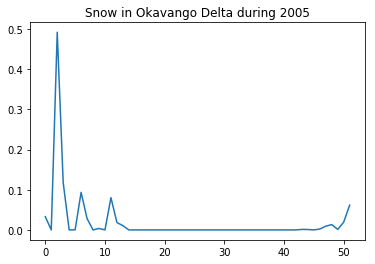

In [24]:
parameter = 'Snow'
year = [2005]
aoi = ['Okavango Delta']

param = [a for a in output if a['year'] in year]

y = []

for i in range(len(param)):
    y.append(param[i]['value'])
    
plt.plot(np.arange(len(y)),y)
plt.title (parameter+' in '+aoi[0]+' during '+str(year[0]));

## Water change

https://global-surface-water.appspot.com/

https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_0_GlobalSurfaceWater

**Water Occurrence Change Intensity**

In [27]:
### ASSETS from GEE lets prepare it to what we need
water = ee.Image('JRC/GSW1_0/GlobalSurfaceWater')
water = water.select('change_norm')

### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.histogram(minBucketWidth=10),
    'scale':1000,
    'crs':'EPSG:4326',
    'tileScale': 16
}

reduction = ee.Image(water).reduceRegions(**regReducer)
myOutput = ee.Feature(None, ee.Image(water).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)}))).getInfo()

output=[]
for region in myOutput['properties']['test']:
    output.append({'value': region['properties']['histogram'] if 'histogram' in region['properties'] else None, 'slug':region['properties']['slug']})
    
with open('water_change.json', 'w') as outfile:
    json.dump(output, outfile)

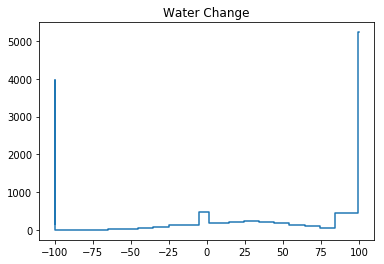

In [28]:
parameter = 'Water Change'
aoi = ['Okavango Delta']

param = [a for a in output if a['slug'] in aoi]

x = param[0]['value']['bucketMeans']
y = param[0]['value']['histogram']

plt.step(x,y);
plt.title (parameter);

**Water Seasonality**

In [29]:
### ASSETS from GEE lets prepare it to what we need
water_seasonality = ee.Image('JRC/GSW1_0/GlobalSurfaceWater')
water_seasonality = water_seasonality.select('seasonality')

### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.histogram(),
    'scale':1000,
    'crs':'EPSG:4326',
    'tileScale': 16
}

reduction = ee.Image(water_seasonality).reduceRegions(**regReducer)
myOutput = ee.Feature(None, ee.Image(water_seasonality).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)}))).getInfo()

output=[]
for region in myOutput['properties']['test']:
    output.append({'value': region['properties']['histogram'] if 'histogram' in region['properties'] else None, 'slug':region['properties']['slug']})
    
with open('water_seasonality.json', 'w') as outfile:
    json.dump(output, outfile)

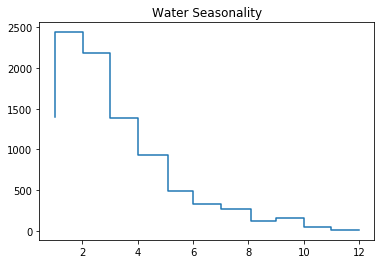

In [30]:
parameter = 'Water Seasonality'
aoi = ['Okavango Delta']

param = [a for a in output if a['slug'] in aoi]

x = param[0]['value']['bucketMeans']
y = param[0]['value']['histogram']

plt.step(x,y);
plt.title (parameter);

## species richness

**Biodiversity Intactness (%)**

In [35]:
### ASSETS from GEE
intactness = ee.Image('users/resourcewatch/bio_014_bio_intactness')

### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.histogram(minBucketWidth=0.1),
    'scale':1000,
    'crs':'EPSG:4326',
    'tileScale': 16
}

reduction = ee.Image(intactness).reduceRegions(**regReducer)
myOutput = ee.Feature(None, ee.Image(intactness).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)}))).getInfo()

output=[]
for region in myOutput['properties']['test']:
    output.append({'value': region['properties']['histogram'] if 'histogram' in region['properties'] else None, 'slug':region['properties']['slug']})
    
with open('biodiversity_intactness.json', 'w') as outfile:
    json.dump(output, outfile)

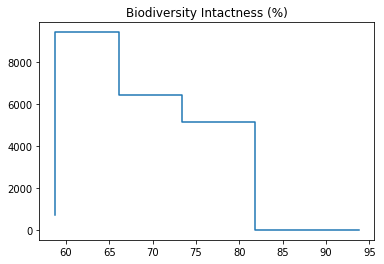

In [34]:
parameter = 'Biodiversity Intactness (%)'
aoi = ['Okavango Delta']

param = [a for a in output if a['slug'] in aoi]

x = param[0]['value']['bucketMeans']
y = param[0]['value']['histogram']

plt.step(np.array(x)*100,y);
plt.title (parameter);

**2013 Number of Mammalian Amphibian and Species** 

In [36]:
### ASSETS from GEE
species_richness = ee.Image('users/resourcewatch/bio_012_species_richness_grids_merged')
amphibian  = species_richness.select('b3')
mammals = species_richness.select('b4')

### Reducer to regions extractor
regReducer = {
    'collection': collection,
    'reducer': ee.Reducer.histogram(minBucketWidth=1),
    'scale':1000,
    'crs':'EPSG:4326',
    'tileScale': 16
}

#Function to extract histograms
def getHist(img):
    reduction = ee.Image(img).reduceRegions(**regReducer)
    myOutput = ee.Feature(None, ee.Image(img).toDictionary().combine(ee.Dictionary({'test':reduction.toList(10)}))).getInfo()
    return myOutput


amphibianOutput = getHist(amphibian)
mammalsOutput = getHist(mammals)

amphibian_output=[]
for region in amphibianOutput['properties']['test']:
    amphibian_output.append({'value': region['properties']['histogram'] if 'histogram' in region['properties'] else None, 'slug':region['properties']['slug']})

mammals_output=[]
for region in mammalsOutput['properties']['test']:
    mammals_output.append({'value': region['properties']['histogram'] if 'histogram' in region['properties'] else None, 'slug':region['properties']['slug']})
    
with open('biodiversity_intactness.json', 'w') as outfile:
    json.dump(output, outfile)

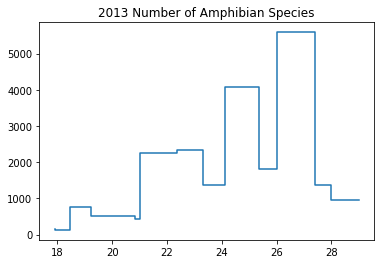

In [37]:
parameter = '2013 Number of Amphibian Species'
aoi = ['Okavango Delta']

param = [a for a in amphibian_output if a['slug'] in aoi]

x = param[0]['value']['bucketMeans']
y = param[0]['value']['histogram']

plt.step(np.array(x),y);
plt.title (parameter);

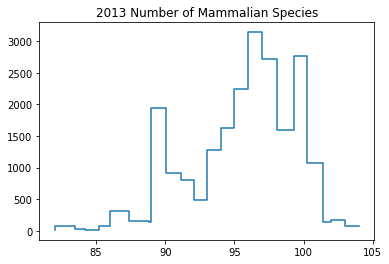

In [38]:
parameter = '2013 Number of Mammalian Species'
aoi = ['Okavango Delta']

param = [a for a in mammals_output if a['slug'] in aoi]

x = param[0]['value']['bucketMeans']
y = param[0]['value']['histogram']

plt.step(np.array(x),y);
plt.title (parameter);

## droughts?